In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.model_selection import RepeatedStratifiedKFold


In [12]:
es = pd.read_csv('ES_intraday.csv',index_col=0)
wec = pd.read_csv('WEC_intraday.csv',index_col=0)

es.sort_index(inplace=True)
wec.sort_index(inplace=True)

In [13]:
spr = es[['close']] - wec[['close']]
spr.dropna(inplace=True)
spr["spread"] = spr["close"]
spr.drop("close",axis=1, inplace=True)

In [36]:
# Reference https://blog.quantinsti.com/pairs-trading-basics/
interval = 24
threshold = 0.5
#df with spread
def strategy_labeling(df, interval, threshold):
    df["rolling_mean"] = df['spread'].rolling(interval).mean()
    df["rolling_std"] = df['spread'].rolling(interval).std()
    df.dropna(inplace=True)
    df["upper_threshold"] = threshold*df["rolling_std"]
    df["lower_threshold"] = - threshold*df["rolling_std"]
    df["z-score"] = (df['spread'] - df["rolling_mean"]) / df["rolling_std"]
    ### 1 is go short (sell es buy wec), 0 is hold, -1 is go long (sell wec buy es) ... I think
    # spr["label"] = 1 if spr[spr["z-score"] > spr["upper_threshold"]] else 0 if spr[spr["z-score"] < spr["lower_threshold"]] else -1
    df['label'] = spr.apply(lambda x: 1 if x["z-score"] > x["upper_threshold"] else 0 if x["z-score"] < x["lower_threshold"] else -1, axis=1)
    return df

spr = strategy_labeling(spr, interval, threshold)
spr['label'].value_counts()


 0    1332
 1    1331
-1    1293
Name: label, dtype: int64

In [37]:
#Train - Test 80/20 split
split = round(0.8*len(spr))
train, test = spr[:split],spr[split:]
x_train = train.copy()
y_train = x_train["label"]
x_train.drop(["upper_threshold", "lower_threshold", "z-score", "rolling_mean", "rolling_std", "label"], axis=1, inplace=True)
x_test = test.copy()
y_test = x_test["label"]
x_test.drop(["upper_threshold", "lower_threshold", "z-score", "rolling_mean", "rolling_std", "label"], axis=1, inplace=True)

In [38]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l1','l2', 'none', 'elasticnet']
c_values = [1e-3, 1e-2, 1e-1, 1, 10]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
model = GridSearchCV(estimator=LogisticRegression(), param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = model.fit(x_train, y_train.values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

Best: 0.392001 using {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'lbfgs'}
0.347864 (0.008523) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'sag'}
0.338709 (0.009017) with: {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}
0.356607 (0.019107) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.356607 (0.019107) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.392001 (0.023700) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.356606 (0.019188) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}
0.356607 (0.019107) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}
0.356395 (0.019412) with: {'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}
0.356395 (0.019412) with: {'C': 0.001, 'penalty': 'none', 'solver': 'lbfgs'}
0.000000

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1350 fits failed out of a total of 3000.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
150 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Library/Framework

In [40]:
y_pred = model.predict(x_test)
print(classification_report(y_test,y_pred))
print(accuracy_score(y_pred, y_test))
print(model.best_params_)

              precision    recall  f1-score   support

          -1       0.24      0.19      0.21       221
           0       0.41      0.45      0.43       306
           1       0.43      0.45      0.44       264

    accuracy                           0.38       791
   macro avg       0.36      0.36      0.36       791
weighted avg       0.37      0.38      0.37       791

0.37926675094816686
{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


In [41]:
joblib.dump(model, 'logreg2.pkl')

['logreg2.pkl']

Graphs

In [24]:
ratio = wec[['close']] / es[['close']]
ratio.dropna(inplace=True)
ratio["ratio"] = ratio["close"]
ratio.drop("close",axis=1, inplace=True)
ratio

,ratio
0,1.134110
1,1.133820
2,1.132798
3,1.128082
4,1.134050
...,...
4089,1.091136
4090,1.091259
4091,1.093076
4092,1.101801


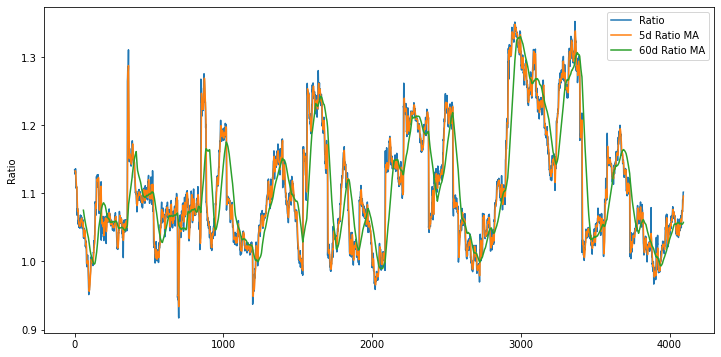

In [25]:
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg60 = ratio.rolling(window=60, center=False).mean()
std_60 = ratio.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

<Figure size 864x432 with 0 Axes>

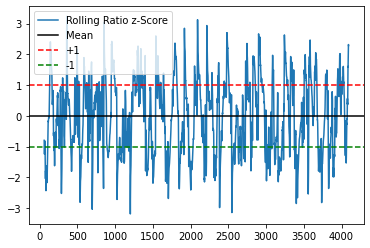

In [31]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
# plt.xlim('2021-09-25', '2022-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [28]:
# plt.figure(figsize=(12,6))

# ratio.plot()
# buy = ratio.copy()
# sell = ratio.copy()
# buy[zscore_60_5>-1] = 0
# sell[zscore_60_5<1] = 0
# buy.plot(color='g', linestyle='None', marker='^')
# sell.plot(color='r', linestyle='None', marker='^')
# x1, x2, y1, y2 = plt.axis()
# # plt.axis((x1, x2, ratio.min(), ratio.max()))
# # plt.xlim('2013-08-15','2016-07-07')
# plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
# plt.show()